In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

In [2]:
with open(f"../intermediate_files/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
with open(f"../training_outputs/first_multiclass_training/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

for prob in ['prob_1gNp', 'prob_1g0p', 'prob_1gNp1mu', 'prob_1g0p1mu', 'prob_1g_outFV', 
             'prob_2gNp', 'prob_2g0p', 'prob_2gNp1mu', 'prob_2g0p1mu', 'prob_2g_outFV', 
             'prob_0g', 'prob_3plusg', 'prob_dirt', 'prob_ext']:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


all_df.shape=(747332, 66)
pred_df.shape=(71178, 20)
weighting up by the fraction of test events: 0.500
merged_df.shape=(35589, 82)
presel_merged_df.shape=(24065, 82)


,run,subrun,event,filetype,wc_net_weight,topological_signal_category,physics_signal_category,wc_nue_score,wc_numu_score,wc_nc_delta_score,...,prob_2gNp,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_1g_outFV,prob_2g_outFV,prob_0g,prob_3plusg,prob_dirt,prob_ext
0,20290,30,1510,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-15.000000,-0.445759,-3.342609,...,0.944316,0.012887,1.939894e-02,2.282868e-05,0.000013,1.762621e-05,0.006040,0.002404,4.051858e-05,0.005249
1,20290,30,1521,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-8.405992,-0.906318,-6.305526,...,0.968448,0.003051,7.341531e-03,4.147832e-06,0.000004,1.541762e-05,0.000262,0.002144,6.533629e-07,0.001253
4,20290,30,1543,nc_pi0_overlay,0.853012,2g0p,NC1pi0_0p,-9.779932,-1.000641,-7.236095,...,0.089629,0.874161,2.223498e-02,1.871407e-04,0.000149,8.101316e-04,0.003184,0.001730,5.785138e-05,0.006017
5,20290,30,1544,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-15.000000,-0.130912,1.638694,...,0.923344,0.027177,1.363644e-03,1.890208e-05,0.000117,2.881535e-05,0.031806,0.001553,7.708088e-05,0.001998
7,20672,75,3754,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-13.695713,-0.727442,-3.236898,...,0.520390,0.418245,2.889775e-02,3.811315e-05,0.001599,1.859842e-04,0.001898,0.000334,1.970582e-04,0.021169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745925,21127,121,6058,ext,15.323285,ext,ext,-15.000000,-0.032794,-3.114151,...,0.000161,0.000050,3.196191e-05,5.289627e-07,0.000043,5.002764e-08,0.031518,0.000002,5.982766e-04,0.967501
746371,20423,551,27581,ext,15.323285,ext,ext,-15.000000,-0.938013,-1.905209,...,0.007844,0.175129,6.537586e-04,4.100300e-06,0.000039,2.133688e-05,0.178338,0.000034,3.507084e-01,0.212352
746558,20194,192,9622,ext,15.323285,ext,ext,-15.000000,-3.454599,-4.554944,...,0.000395,0.000179,3.773692e-07,4.059885e-07,0.000007,5.814323e-06,0.000631,0.000008,5.558229e-04,0.996964
746934,20154,269,13456,ext,15.323285,ext,ext,-15.000000,-0.014429,-5.872269,...,0.002773,0.018757,4.403330e-04,1.224039e-05,0.000016,3.093149e-07,0.361572,0.000023,3.486222e-04,0.615344


# 1g and 2g

  0%|          | 0/15 [00:00<?, ?it/s]

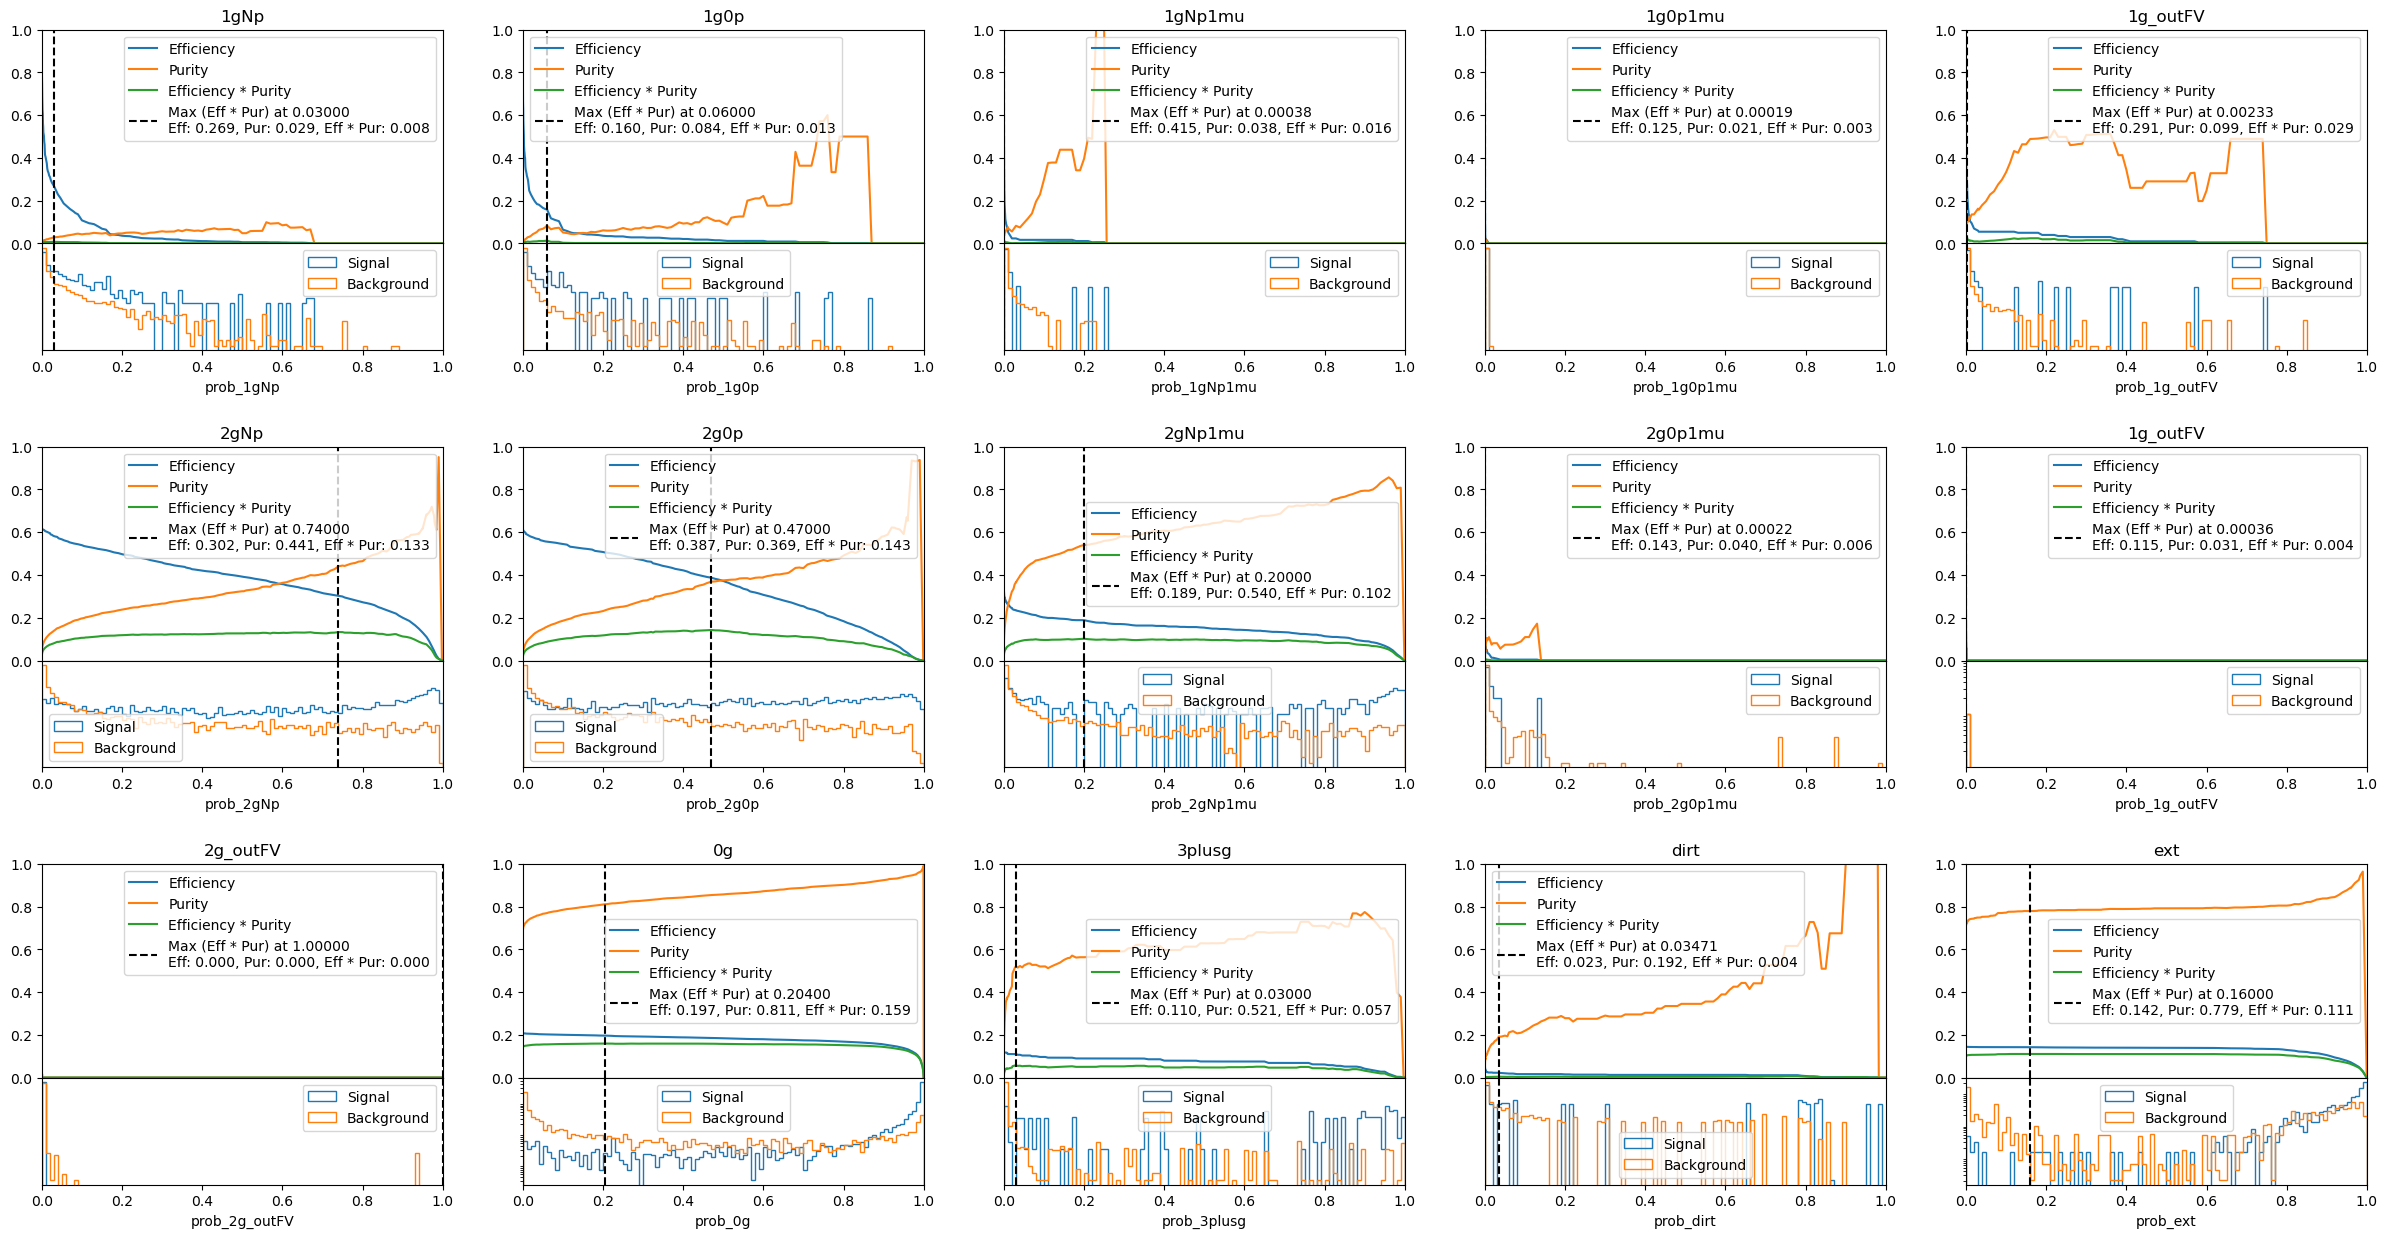

In [3]:
weights = merged_df["wc_net_weight"].to_numpy()
presel_mask = (merged_df["wc_kine_reco_Enu"] > 0) & (merged_df["wc_shw_sp_n_20mev_showers"] > 0)
sig_categories = merged_df["topological_signal_category"].to_numpy()

already_selected_mask = np.zeros(merged_df.shape[0], dtype=bool)

plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(30, 15))

all_cutoffs = []

prob_types = [
    'prob_1gNp',
    'prob_1g0p',
    'prob_1gNp1mu',
    'prob_1g0p1mu',
    'prob_1g_outFV',
    'prob_2gNp',
    'prob_2g0p',
    'prob_2gNp1mu',
    'prob_2g0p1mu',
    'prob_1g_outFV',
    'prob_2g_outFV',
    'prob_0g',
    'prob_3plusg',
    'prob_dirt',
    'prob_ext',
]

for i in tqdm(range(len(prob_types))):
    prob = prob_types[i]

    signal_category = prob[5:]
    probabilities = merged_df[prob].to_numpy()
    total_sig = weights[sig_categories == signal_category].sum()

    max_eff = 0
    max_pur = 0
    max_eff_times_pur = 0
    max_eff_times_pur_cutoff = 1 # default to no selection

    all_eff = []
    all_pur = []
    all_eff_times_pur = []

    uniform_test_cutoff_points = np.linspace(0, 1, 101)
    quantile_test_cutoff_points = np.quantile(probabilities[presel_mask], np.linspace(0, 1, 101))
    test_cutoff_points = np.sort(np.concatenate([uniform_test_cutoff_points, quantile_test_cutoff_points]))

    for cutoff in test_cutoff_points:

        if signal_category == 'other':
            cutoff = 0

        sig_sel = weights[(sig_categories == prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()
        bkg_sel = weights[(sig_categories != prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()

        eff = sig_sel / total_sig
        if sig_sel + bkg_sel > 0:
            pur = sig_sel / (sig_sel + bkg_sel)
        else:
            pur = 0
        eff_times_pur = eff * pur

        all_eff.append(eff)
        all_pur.append(pur)
        all_eff_times_pur.append(eff_times_pur)

        num_sel_events = len(weights[presel_mask & (probabilities > cutoff) & (~already_selected_mask)])

        if eff_times_pur > max_eff_times_pur and pur > 0.02 and num_sel_events > 50: # only allow a selection with reasonable purity and enough MC stats
            max_eff = eff
            max_pur = pur
            max_eff_times_pur = eff_times_pur
            max_eff_times_pur_cutoff = cutoff

        if signal_category == 'other':
            continue


    gs = fig.add_gridspec(3, 5, hspace=0.3, wspace=0.2)
    row = i // 5
    col = i % 5
    
    # Create nested gridspec for the two panels
    nested_gs = gs[row, col].subgridspec(2, 1, height_ratios=[2, 1], hspace=0)
    
    ax1 = fig.add_subplot(nested_gs[0])
    ax2 = fig.add_subplot(nested_gs[1])

    # Upper panel - metrics vs cutoff
    ax1.plot(test_cutoff_points, all_eff, label="Efficiency")
    ax1.plot(test_cutoff_points, all_pur, label="Purity")
    ax1.plot(test_cutoff_points, all_eff_times_pur, label="Efficiency * Purity")
    ax1.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--', label=f"Max (Eff * Pur) at {max_eff_times_pur_cutoff:.5f}\nEff: {max_eff:.3f}, Pur: {max_pur:.3f}, Eff * Pur: {max_eff_times_pur:.3f}")
    ax1.legend()
    ax1.set_title(f"{signal_category}")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xticks([])

    # Lower panel - probability distributions
    sig_mask = (sig_categories == signal_category) & (~already_selected_mask)
    bkg_mask = ~sig_mask & (~already_selected_mask)
    
    sig_probs = probabilities[sig_mask & presel_mask & (probabilities > 0)]
    bkg_probs = probabilities[bkg_mask & presel_mask & (probabilities > 0)]
    sig_weights = weights[sig_mask & presel_mask & (probabilities > 0)]
    bkg_weights = weights[bkg_mask & presel_mask & (probabilities > 0)]

    bins = np.linspace(0, 1, 101)
    ax2.hist(sig_probs, bins=bins, weights=sig_weights, histtype='step', label='Signal', density=True)
    ax2.hist(bkg_probs, bins=bins, weights=bkg_weights, histtype='step', label='Background', density=True)
    ax2.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--')
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel(prob)
    ax2.set_xlim(0, 1)
    ax2.set_yticks([])

    already_selected_mask[probabilities > max_eff_times_pur_cutoff] = True

    all_cutoffs.append(max_eff_times_pur_cutoff)

plt.show()

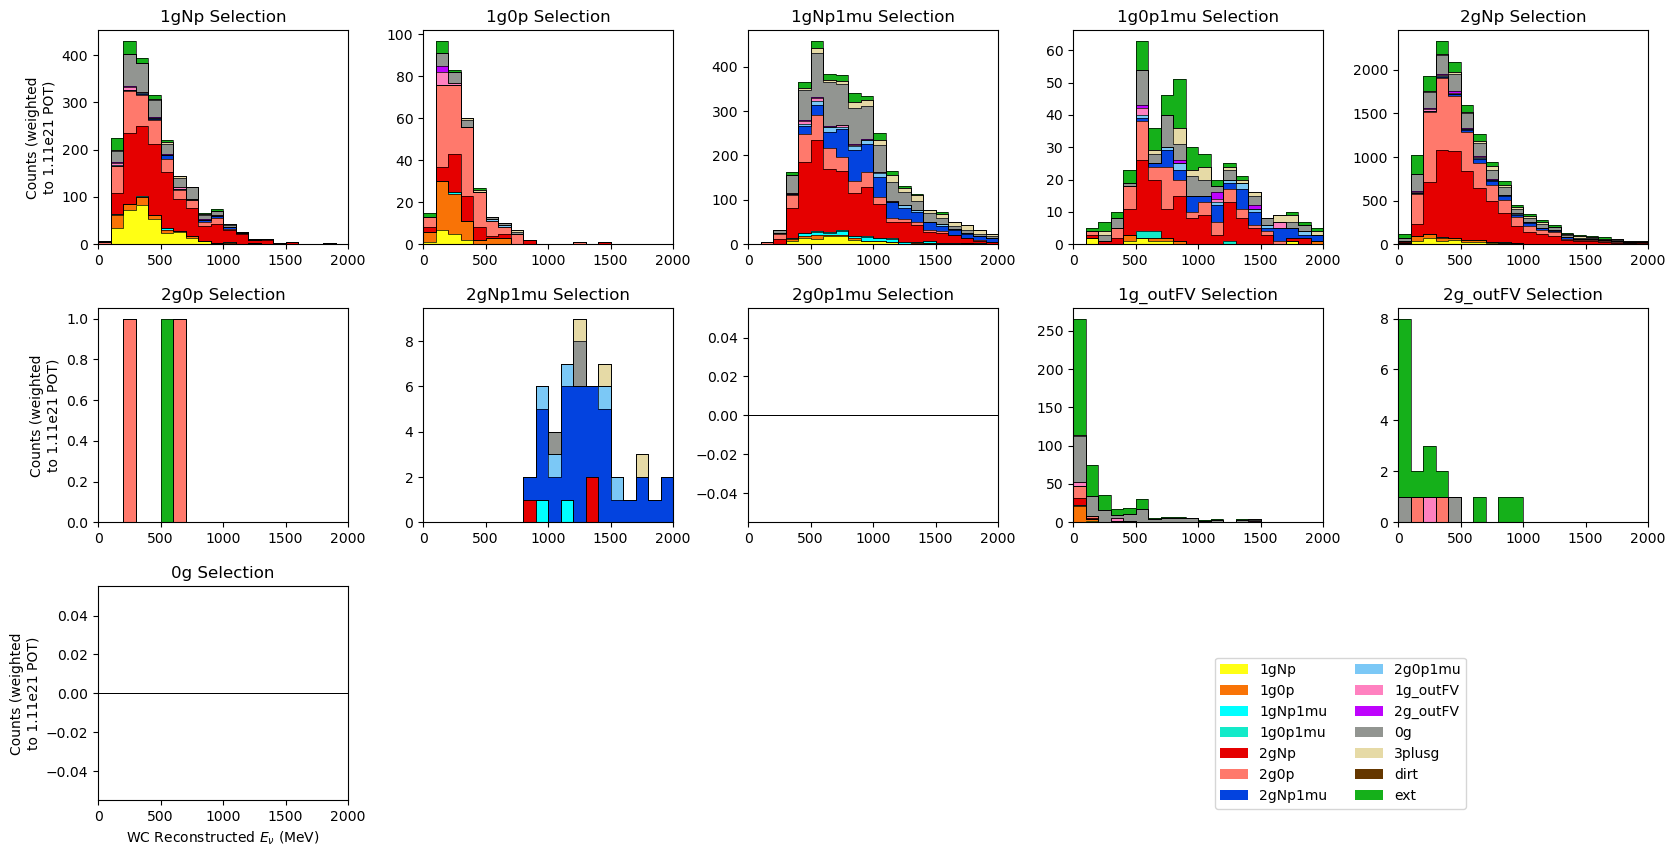

In [4]:
simple_queries = []
for i, signal_category in enumerate([
        "1gNp",
        "1g0p",
        "1gNp1mu",
        "1g0p1mu",
        "2gNp",
        "2g0p",
        "2gNp1mu",
        "2g0p1mu",
        "1g_outFV",
        "2g_outFV",
        "0g",
        "3plusg",
        "dirt",
        "ext",
    ]):
    simple_queries.append(f"prob_{signal_category} > {all_cutoffs[i]:.5f}")

queries = []
for i in range(len(simple_queries)):
    if i == 0:
        queries.append(f"{simple_queries[0]}")
    else:
        queries.append(f"{simple_queries[i]} and {queries[-1].replace('>', '<')}")


breakdown_dic = {
    '1gNp': "xkcd:yellow",
    '1g0p': "xkcd:orange", 
    '1gNp1mu': "xkcd:cyan",
    '1g0p1mu': "xkcd:aqua",
    '2gNp': "xkcd:red",
    '2g0p': "xkcd:salmon",
    '2gNp1mu': "xkcd:blue",
    '2g0p1mu': "xkcd:lightblue",
    '1g_outFV': "xkcd:pink",
    '2g_outFV': "xkcd:bright purple",
    '0g': "xkcd:gray",
    '3plusg': "xkcd:beige",
    'dirt': "xkcd:brown",
    'ext': "xkcd:green",
}

breakdown_labels = list(breakdown_dic.keys())
colors = list(breakdown_dic.values())

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs = axs.flatten()

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_dic)
outline_colors = ["k"] * len(breakdown_dic)

for i, signal_category in enumerate([
        "1gNp",
        "1g0p",
        "1gNp1mu",
        "1g0p1mu",
        "2gNp",
        "2g0p",
        "2gNp1mu",
        "2g0p1mu",
        "1g_outFV",
        "2g_outFV",
        "0g",
        "3plusg",
        "dirt",
        "ext",
    ]):

    sel_df = presel_merged_df.query(queries[i])

    counts = []
    for k in breakdown_dic:
        if k == 'dirt':
            curr_df = sel_df.query(f"filetype == 'dirt'")
        elif k == 'ext':
            curr_df = sel_df.query(f"filetype == 'ext'")
        elif k in [
                "1gNp",
                "1g0p",
                "1gNp1mu",
                "1g0p1mu",
                "2gNp",
                "2g0p",
                "2gNp1mu",
                "2g0p1mu",
                "1g_outFV",
                "2g_outFV",
                "0g",
                "3plusg",
            ]:
            curr_df = sel_df.query(f"filetype != 'dirt' and filetype != 'ext' and topological_signal_category == '{k}'")
        else:
            raise ValueError(f"Invalid signal category: {k}")
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=colors, stacked=True, label=breakdown_labels)
    axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
    
    if i >= 10: # Only show x-label for bottom row
        axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    if i % 5 == 0: # Only show y-label for leftmost column
        axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
    axs[i].set_title(f"{signal_category} Selection")
    axs[i].set_xlim(0, 2000)
    
    if i == 10:
        axs[i].legend(ncol=2, loc='upper right', bbox_to_anchor=(5.5, 0.7))

for ax in axs[11:15]:
    ax.remove()

fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()



# 2g Only

  0%|          | 0/9 [00:00<?, ?it/s]

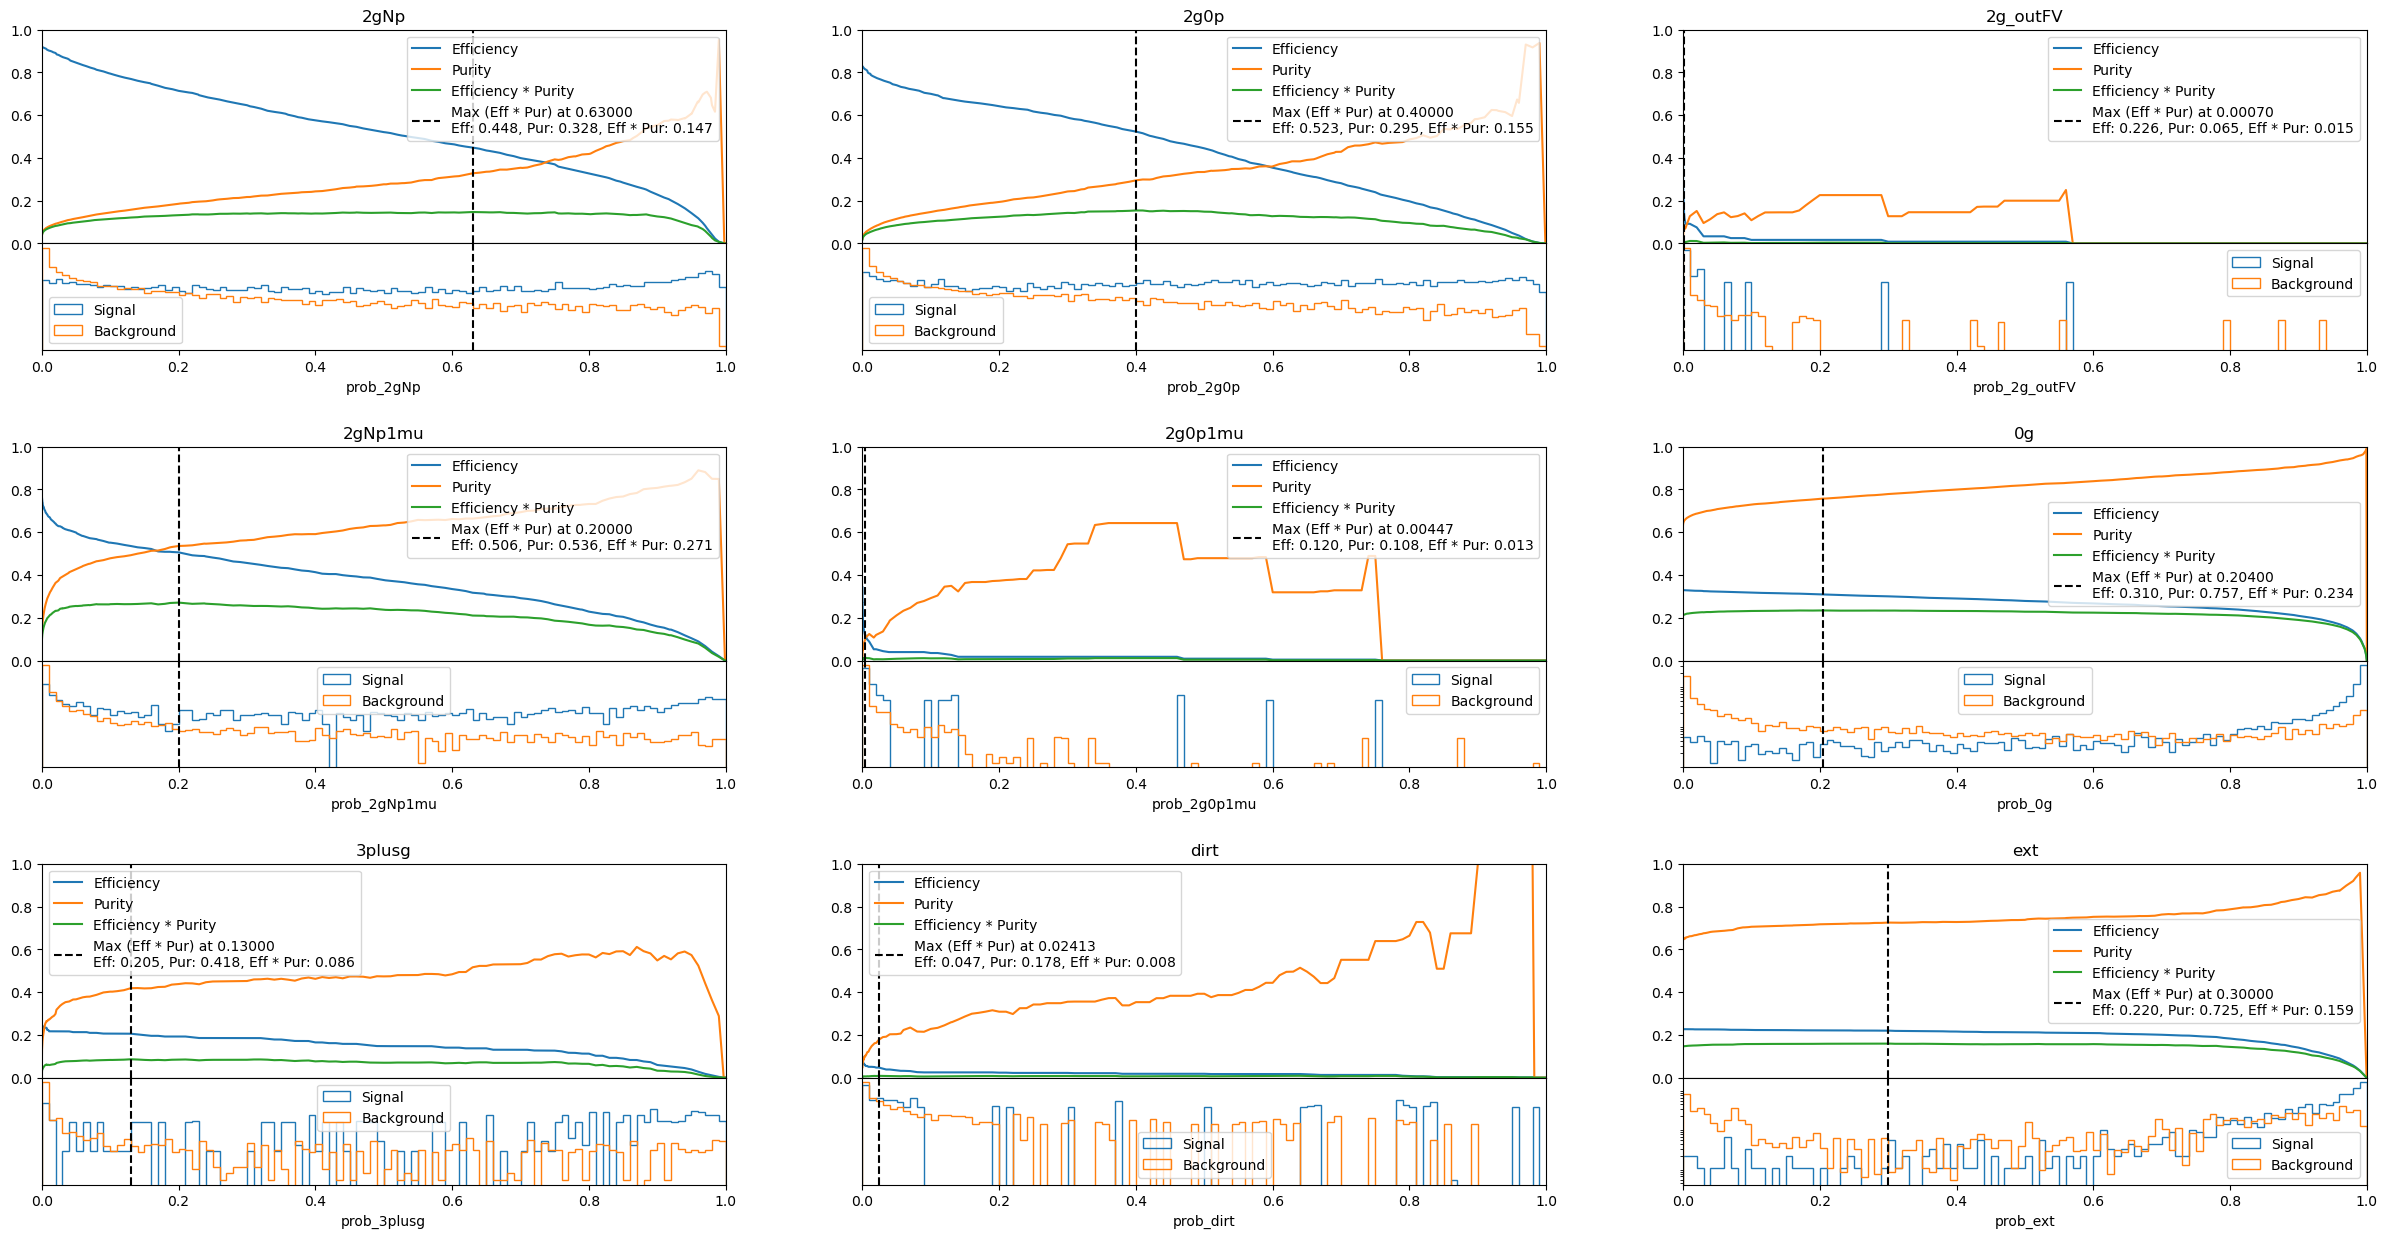

In [5]:
weights = merged_df["wc_net_weight"].to_numpy()
presel_mask = (merged_df["wc_kine_reco_Enu"] > 0) & (merged_df["wc_shw_sp_n_20mev_showers"] > 0)
sig_categories = merged_df["topological_signal_category"].to_numpy()

already_selected_mask = np.zeros(merged_df.shape[0], dtype=bool)

plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(30, 15))

all_cutoffs = []

prob_types = [
    'prob_2gNp',
    'prob_2g0p',
    'prob_2gNp1mu',
    'prob_2g0p1mu',
    'prob_2g_outFV',
    'prob_0g',
    'prob_3plusg',
    'prob_dirt',
    'prob_ext',
]

for i in tqdm(range(len(prob_types))):
    prob = prob_types[i]

    signal_category = prob[5:]
    probabilities = merged_df[prob].to_numpy()
    total_sig = weights[sig_categories == signal_category].sum()

    max_eff = 0
    max_pur = 0
    max_eff_times_pur = 0
    max_eff_times_pur_cutoff = 1 # default to no selection

    all_eff = []
    all_pur = []
    all_eff_times_pur = []

    uniform_test_cutoff_points = np.linspace(0, 1, 101)
    quantile_test_cutoff_points = np.quantile(probabilities[presel_mask], np.linspace(0, 1, 101))
    test_cutoff_points = np.sort(np.concatenate([uniform_test_cutoff_points, quantile_test_cutoff_points]))

    for cutoff in test_cutoff_points:

        sig_sel = weights[(sig_categories == prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()
        bkg_sel = weights[(sig_categories != prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()

        eff = sig_sel / total_sig
        if sig_sel + bkg_sel > 0:
            pur = sig_sel / (sig_sel + bkg_sel)
        else:
            pur = 0
        eff_times_pur = eff * pur

        all_eff.append(eff)
        all_pur.append(pur)
        all_eff_times_pur.append(eff_times_pur)

        num_sel_events = len(weights[presel_mask & (probabilities > cutoff) & (~already_selected_mask)])

        if eff_times_pur > max_eff_times_pur and pur > 0.02 and num_sel_events > 50: # only allow a selection with reasonable purity and enough MC stats
            max_eff = eff
            max_pur = pur
            max_eff_times_pur = eff_times_pur
            max_eff_times_pur_cutoff = cutoff


    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.2)
    reorder_indices = [0, 1, 3, 4, 2, 5, 6, 7, 8]
    row = reorder_indices[i] // 3
    col = reorder_indices[i] % 3
    
    # Create nested gridspec for the two panels
    nested_gs = gs[row, col].subgridspec(2, 1, height_ratios=[2, 1], hspace=0)
    
    ax1 = fig.add_subplot(nested_gs[0])
    ax2 = fig.add_subplot(nested_gs[1])

    # Upper panel - metrics vs cutoff
    ax1.plot(test_cutoff_points, all_eff, label="Efficiency")
    ax1.plot(test_cutoff_points, all_pur, label="Purity")
    ax1.plot(test_cutoff_points, all_eff_times_pur, label="Efficiency * Purity")
    ax1.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--', label=f"Max (Eff * Pur) at {max_eff_times_pur_cutoff:.5f}\nEff: {max_eff:.3f}, Pur: {max_pur:.3f}, Eff * Pur: {max_eff_times_pur:.3f}")
    ax1.legend()
    ax1.set_title(f"{signal_category}")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xticks([])

    # Lower panel - probability distributions
    sig_mask = (sig_categories == signal_category) & (~already_selected_mask)
    bkg_mask = ~sig_mask & (~already_selected_mask)
    
    sig_probs = probabilities[sig_mask & presel_mask & (probabilities > 0)]
    bkg_probs = probabilities[bkg_mask & presel_mask & (probabilities > 0)]
    sig_weights = weights[sig_mask & presel_mask & (probabilities > 0)]
    bkg_weights = weights[bkg_mask & presel_mask & (probabilities > 0)]

    bins = np.linspace(0, 1, 101)
    ax2.hist(sig_probs, bins=bins, weights=sig_weights, histtype='step', label='Signal', density=True)
    ax2.hist(bkg_probs, bins=bins, weights=bkg_weights, histtype='step', label='Background', density=True)
    ax2.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--')
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel(prob)
    ax2.set_xlim(0, 1)
    ax2.set_yticks([])

    already_selected_mask[probabilities > max_eff_times_pur_cutoff] = True

    all_cutoffs.append(max_eff_times_pur_cutoff)

plt.show()

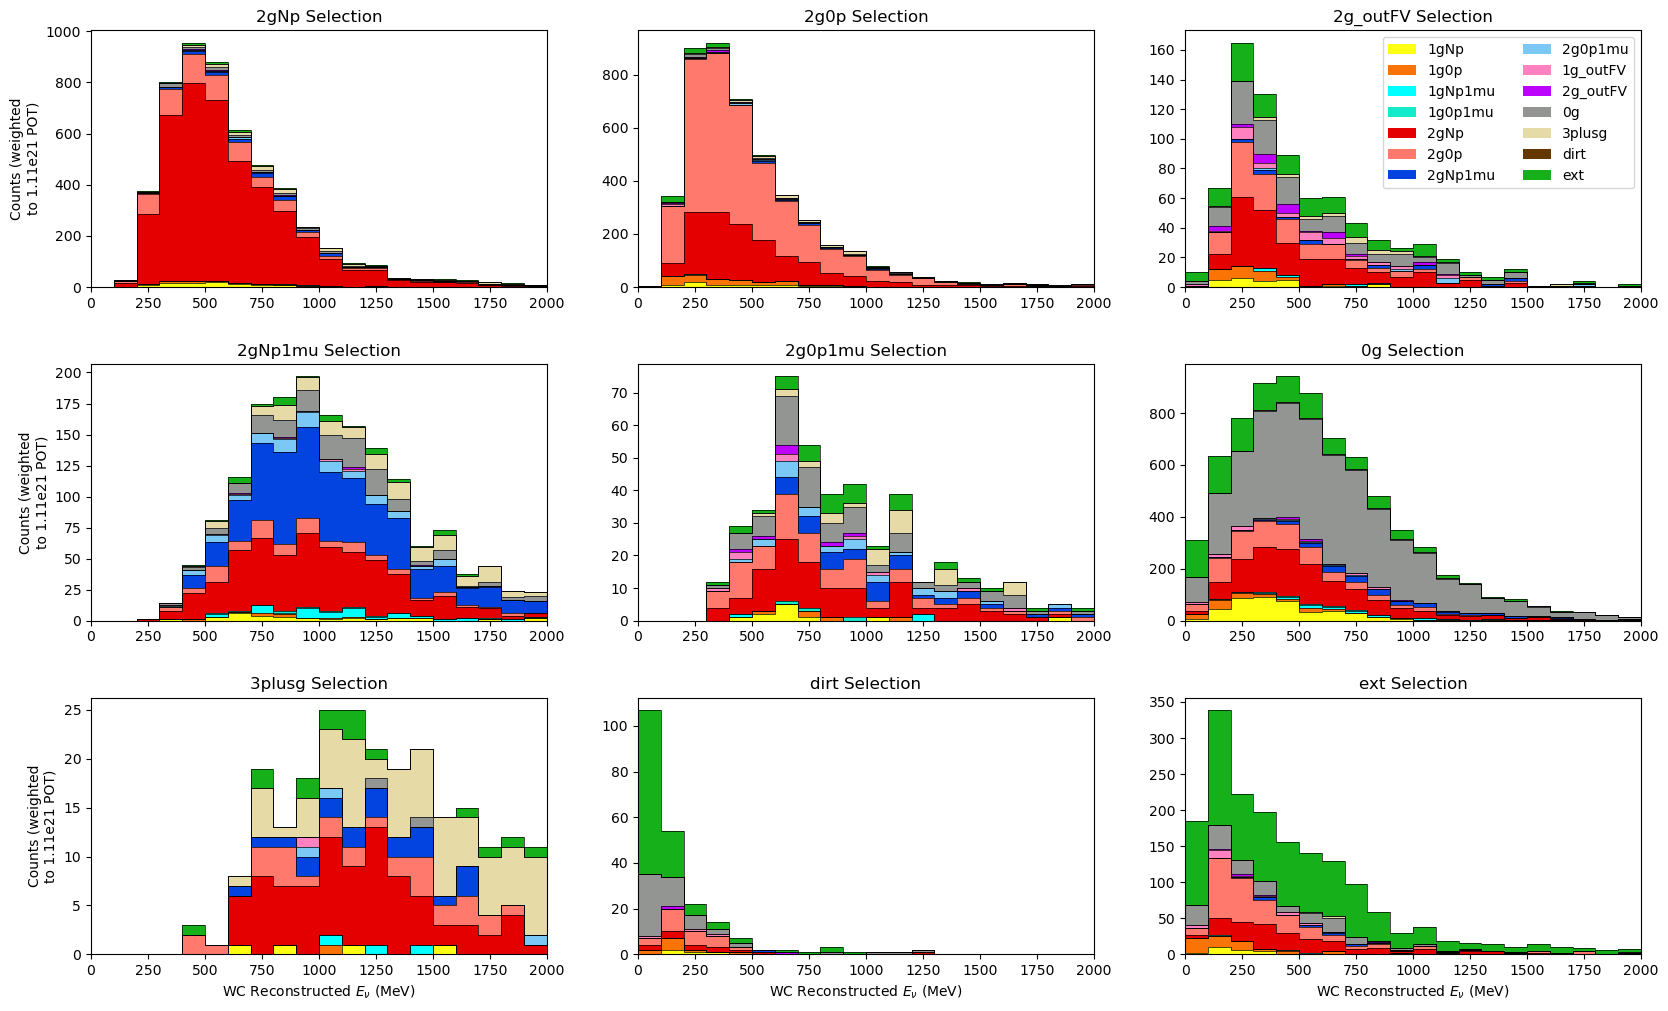

In [11]:
simple_queries = []
for i, signal_category in enumerate([
        "2gNp",
        "2g0p",
        "2gNp1mu",
        "2g0p1mu",
        "2g_outFV",
        "0g",
        "3plusg",
        "dirt",
        "ext",
    ]):
    simple_queries.append(f"prob_{signal_category} > {all_cutoffs[i]:.5f}")

queries = []
for i in range(len(simple_queries)):
    if i == 0:
        queries.append(f"{simple_queries[0]}")
    else:
        queries.append(f"{simple_queries[i]} and {queries[-1].replace('>', '<')}")


breakdown_dic = {
    '1gNp': "xkcd:yellow",
    '1g0p': "xkcd:orange", 
    '1gNp1mu': "xkcd:cyan",
    '1g0p1mu': "xkcd:aqua",
    '2gNp': "xkcd:red",
    '2g0p': "xkcd:salmon",
    '2gNp1mu': "xkcd:blue",
    '2g0p1mu': "xkcd:lightblue",
    '1g_outFV': "xkcd:pink",
    '2g_outFV': "xkcd:bright purple",
    '0g': "xkcd:gray",
    '3plusg': "xkcd:beige",
    'dirt': "xkcd:brown",
    'ext': "xkcd:green",
}

breakdown_labels = list(breakdown_dic.keys())
colors = list(breakdown_dic.values())

fig, axs = plt.subplots(3, 3, figsize=(20, 12))
axs = axs.flatten()
reordered_axs = [axs[0], axs[1], axs[3], axs[4], axs[2], axs[5], axs[6], axs[7], axs[8]]

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_dic)
outline_colors = ["k"] * len(breakdown_dic)

for i, signal_category in enumerate([
        "2gNp",
        "2g0p",
        "2gNp1mu",
        "2g0p1mu",
        "2g_outFV",
        "0g",
        "3plusg",
        "dirt",
        "ext",
    ]):

    sel_df = presel_merged_df.query(queries[i])

    counts = []
    for k in breakdown_dic:
        if k == 'dirt':
            curr_df = sel_df.query(f"filetype == 'dirt'")
        elif k == 'ext':
            curr_df = sel_df.query(f"filetype == 'ext'")
        elif k in [
                "1gNp",
                "1g0p",
                "1gNp1mu",
                "1g0p1mu",
                "2gNp",
                "2g0p",
                "2gNp1mu",
                "2g0p1mu",
                "1g_outFV",
                "2g_outFV",
                "0g",
                "3plusg",
            ]:
            curr_df = sel_df.query(f"filetype != 'dirt' and filetype != 'ext' and topological_signal_category == '{k}'")
        else:
            raise ValueError(f"Invalid signal category: {k}")
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    reordered_axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=colors, stacked=True, label=breakdown_labels)
    reordered_axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
    
    if i >= 6: # Only show x-label for bottom row
        axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    if i % 3 == 0: # Only show y-label for leftmost column
        axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
    reordered_axs[i].set_title(f"{signal_category} Selection")
    axs[i].set_xlim(0, 2000)
    
    if i == 4:
        reordered_axs[i].legend(ncol=2, loc='upper right')

fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()

